In [1]:
from useful_scit.imps import *
# noinspection PyUnresolvedReferences
import flexpart_management.modules.FLEXOUT as FO
import flexpart_management.modules.flx_array as fa
import flexpart_management.modules.constants as co
import matplotlib.colors as mpl_colors

reload


# Functions

In [2]:
# noinspection PyShadowingNames
def plot_combined_log_pol_coords( ds01 , ds02 , r_distance_limit=2.5 ) :
    f , ax = plt.subplots()
    # noinspection PyTypeChecker
    limit_ = { co.R_CENTER : slice( 0 , r_distance_limit ) }
    _ds2_sliced = ds02.loc[ limit_ ]
    plot_th_r( ds01 , ax )
    qmesh = plot_th_r( _ds2_sliced , ax )
    f: plt.Figure
    f.colorbar( qmesh , ax=ax )
    ax: plt.Axes
    ax.set_title( 'combined domain log pol coords' )
    old_title = ax.title.get_text()
    date_ = ds01.attrs[ "date" ]
    new_title = f'{old_title}\n{date_}'
    ax.set_title( new_title )
    # plt.show()
    return ax


# noinspection PyShadowingNames
def plot_r_z_combined_log_pol_coords( ds01 , ds02 , r_distance_limit=2.5 ) :
    f , ax = plt.subplots()
    # noinspection PyTypeChecker
    slice___ = { co.R_CENTER : slice( 0 , r_distance_limit ) }
    _ds2_sliced = ds02.loc[ slice___ ]
    plot_r_z( ds01 , ax )
    qmesh = plot_r_z( _ds2_sliced , ax )
    f: plt.Figure
    f.colorbar( qmesh , ax=ax )
    ax: plt.Axes
    ax.set_title( 'combined domain log pol coords' )
    ax.set_xlim( 0 , 30 )
    old_title = ax.title.get_text()
    date_ = ds01.attrs[ "date" ]
    new_title = f'{old_title}\n{date_}'
    ax.set_title( new_title )
    return ax


# noinspection PyShadowingNames
def plot_th_r( ds , ax ) :
    sum_geo_ = [ co.ZT , co.RL ]
    plot_threshold = 1e2
    qmesh = plot_qmesh( ds , ax , plot_threshold , sum_geo_ )
    return qmesh


# noinspection PyShadowingNames
def plot_r_z( ds , ax ) :
    sum_geo_ = [ co.TH_CENTER , co.RL ]
    plot_threshold = 1e2
    qmesh = plot_qmesh( ds , ax ,
                        plot_threshold ,
                        sum_geo_ ,
                        x=co.R_CENTER ,
                        y=co.ZM ,
                        yscale='linear' ,
                        ylim_m=250 ,
                        ylim_M=30000
                        )
    return qmesh


# noinspection PyShadowingNames
def plot_qmesh( ds , ax ,
                plot_threshold ,
                sum_dims ,
                x=co.TH_CENTER ,
                y=co.R_CENTER ,
                yscale='log' ,
                ylim_m=.2 ,
                ylim_M=20 ) :
    vmin = 1e1
    vmax = 1e5
    cmap = plt.get_cmap( 'Reds' )
    conc__sum: xr.DataArray = ds[ co.CONC ].sum( sum_dims )
    conc__sum = conc__sum.where( conc__sum > plot_threshold )
    qmesh = conc__sum.plot( ax=ax ,
                            add_colorbar=False ,
                            vmin=vmin ,
                            vmax=vmax ,
                            cmap=cmap ,
                            x=x ,
                            y=y
                            )
    ax: plt.Axes
    ax.set_ylim( ylim_m , ylim_M )
    ax.set_yscale( yscale )
    return qmesh

In [3]:

# noinspection PyShadowingNames
def get_ds_dom_file( dom01_pat , path , i_file=10 ) :
    files = get_file_list( dom01_pat , path )
    file = files[ i_file ]
    print( file )
    ds = xr.open_dataset( file )
    ds = fa.add_zmid( ds )
    return ds


# noinspection PyShadowingNames
def get_file_list( dom01_pat , path ) :
    files = glob.glob( os.path.join( path , dom01_pat ) )
    files.sort()
    return files


# noinspection PyShadowingNames
def get_df_file_list( path , dom='*d01*' ) :
    file_list = get_file_list( dom , path=path )
    path = 'path'
    base_name = 'base_name'
    date = 'date'
    dom = 'dom'

    df_file_list = pd.DataFrame( file_list , columns=[ path ] )
    df_file_list[ base_name ] = df_file_list[ path ].apply(
        lambda p : os.path.basename( p )
        )
    date_patt = '%Y-%m-%d_%H-%M-%S'
    patt = 'd.._(.*)\.nc'
    _dfbn = df_file_list[ base_name ]
    _dfbn = _dfbn.str.extract( patt )[ 0 ]
    df_file_list[ date ] = pd.to_datetime( _dfbn , format=date_patt )
    df_file_list = df_file_list.set_index( date )

    patt = '(d..)_.*\.nc'
    _dfbn = df_file_list[ base_name ]
    _dfbn = _dfbn.str.extract( patt )[ 0 ]
    df_file_list[ dom ] = _dfbn
    return df_file_list


# noinspection PyShadowingNames
def get_merged_file_df( path ) :
    df_file_list_1 = get_df_file_list( path , dom='*d01*' )
    df_file_list_2 = get_df_file_list( path , dom='*d02*' )
    df_d1_d2 = pd.merge( df_file_list_1 ,
                         df_file_list_2 ,
                         left_index=True ,
                         right_index=True ,
                         suffixes=[ '_d01' , '_d02' ]
                         )
    return df_d1_d2


# noinspection PyShadowingNames
def open_ds_from_row_dom( row , dom ) :
    ds01 = xr.open_dataset( row[ 'path_' + dom ] )
    ds01: xr.Dataset = fa.add_zmid( ds01 )
    ds01 = ds01.assign_attrs( { 'date' : row.name } )
    return ds01


# noinspection PyShadowingNames
def join_log_pol_dom_ds( ds01: xr.Dataset ,
                         ds02: xr.Dataset ,
                         threshold: float
                         ) -> xr.Dataset :
    """
    comines low res `ds01` and high res `ds02` `xr.Datasets`
    based on the `threshold`

    Parameters
    ----------
    ds01
        low res dataset
    ds02
        high res dataset
    threshold
        limit for the combination in degree radian units
    Returns
    -------
    xr.Dataset
        the combined dataset
    """
    r_vector = ds01[ co.R_CENTER ]
    r_is_big_mask = r_vector >= threshold
    ds01_trimmed = ds01.where( r_is_big_mask , drop=True )

    r_vector = ds02[ co.R_CENTER ]
    r_is_small_mask = (r_vector < threshold) & (r_vector > .01)
    ds02_trimmed = ds02.where( r_is_small_mask , drop=True )

    # noinspection PyTypeChecker
    ds_trimmed: xr.Dataset = xr.concat( [ ds02_trimmed , ds01_trimmed ] ,
                                        dim=co.R_CENTER )
    return ds_trimmed

In [4]:
def plot_log_custom( dsum , vmax , vmin , map_fun=fa.get_ax_bolivia ) :
    ax = map_fun( fig_args={ 'figsize' : (10 , 8) } )
    pargs_ = { 'norm' : mpl_colors.LogNorm( vmin=vmin ) }
    fa.logpolar_plot( dsum , ax=ax , perM=vmax , perm=vmin ,
                      quantile=False ,
                      patch_args=pargs_ ,
                      drop_zeros=False ,
                      )

In [5]:
# def main(  ) :

In [6]:
path = '/homeappl/home/aliagadi/wrk/' \
   'DONOTREMOVE/flexpart_management_data' \
   '/runs/run_2019-10-02_13-42-52_/log_pol' \
   '/run_2019-10-02_13-42-52_/'

In [7]:
df_d1_d2 = get_merged_file_df( path )
print( len( df_d1_d2 ) )
loc = 23
row = df_d1_d2.iloc[ loc ]
ds01 = open_ds_from_row_dom( row , 'd01' )
ds02 = open_ds_from_row_dom( row , 'd02' )

177


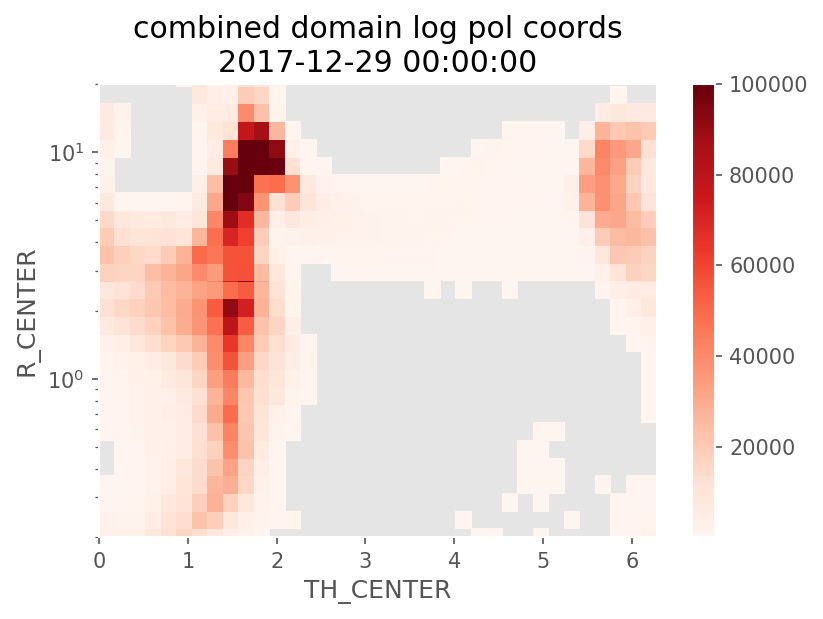

In [8]:
threshold = 2.5
ucp.set_dpi( 150 )
ax = plot_combined_log_pol_coords(
    ds01 , ds02 ,
    r_distance_limit=threshold
    )

plt.show()

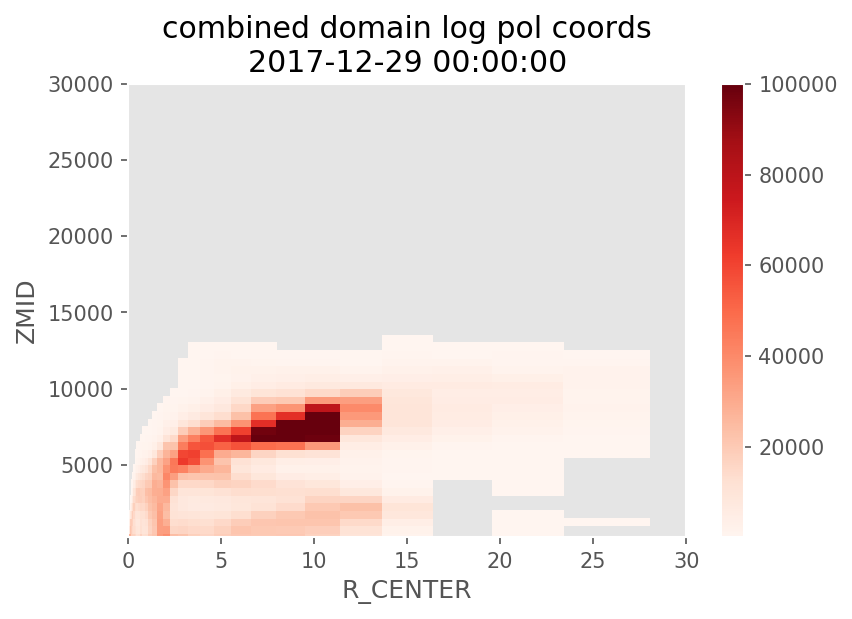

In [9]:
# noinspection PyRedeclaration
ax = plot_r_z_combined_log_pol_coords(
    ds01 , ds02 ,
    r_distance_limit=threshold )
plt.show()

In [10]:
# fa.get_ax_bolivia()
# fa.get_combined_flx_ds()
# plt.show()

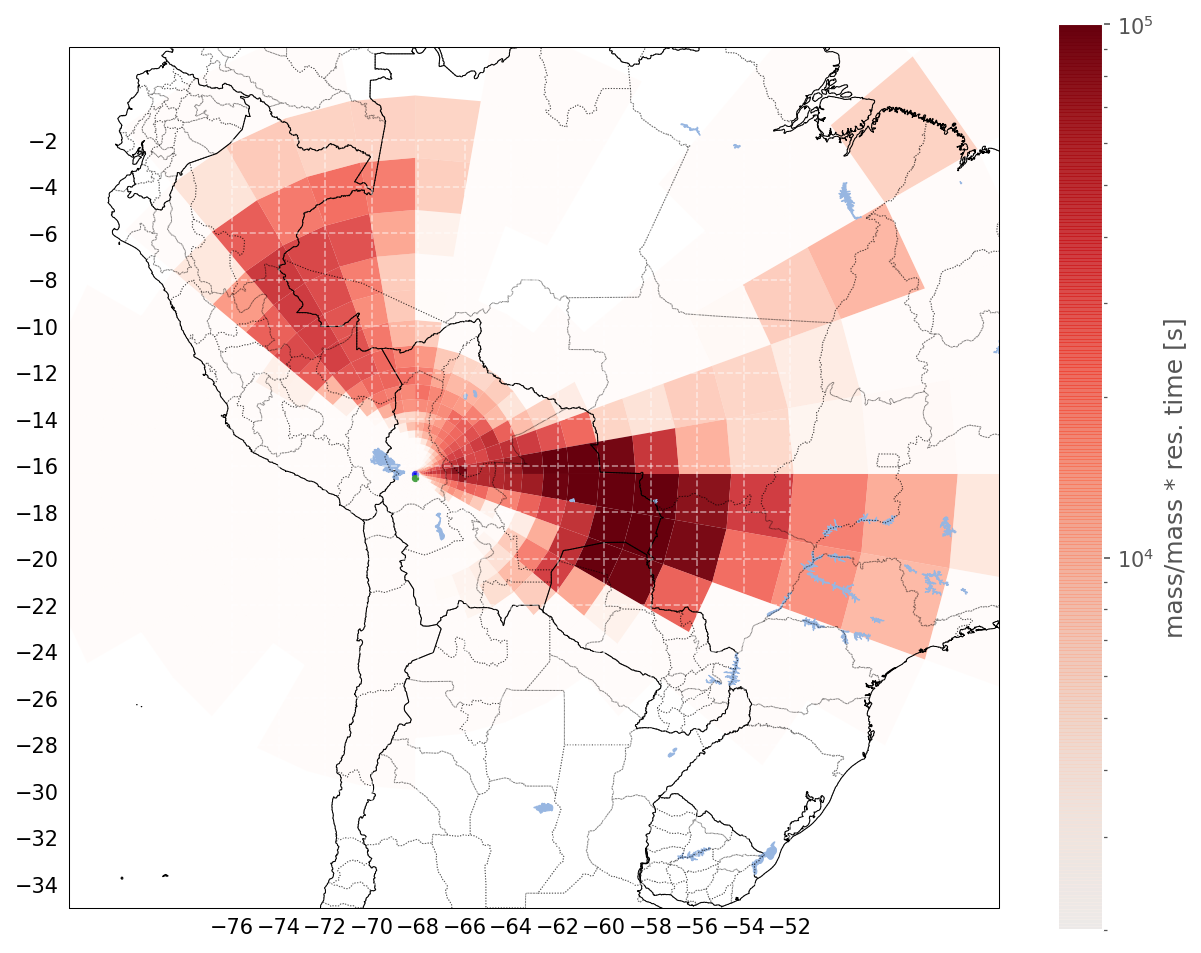

In [11]:
ds12 = join_log_pol_dom_ds( ds01=ds01 , ds02=ds02 , threshold=threshold )
dsum = ds12.sum( [ co.RL , co.ZTOP ] )

vmin = 2e3
vmax = 1e5
# noinspection PyRedeclaration
plot_log_custom( dsum , vmax , vmin, map_fun=fa.get_ax_bolivia )
plt.show()

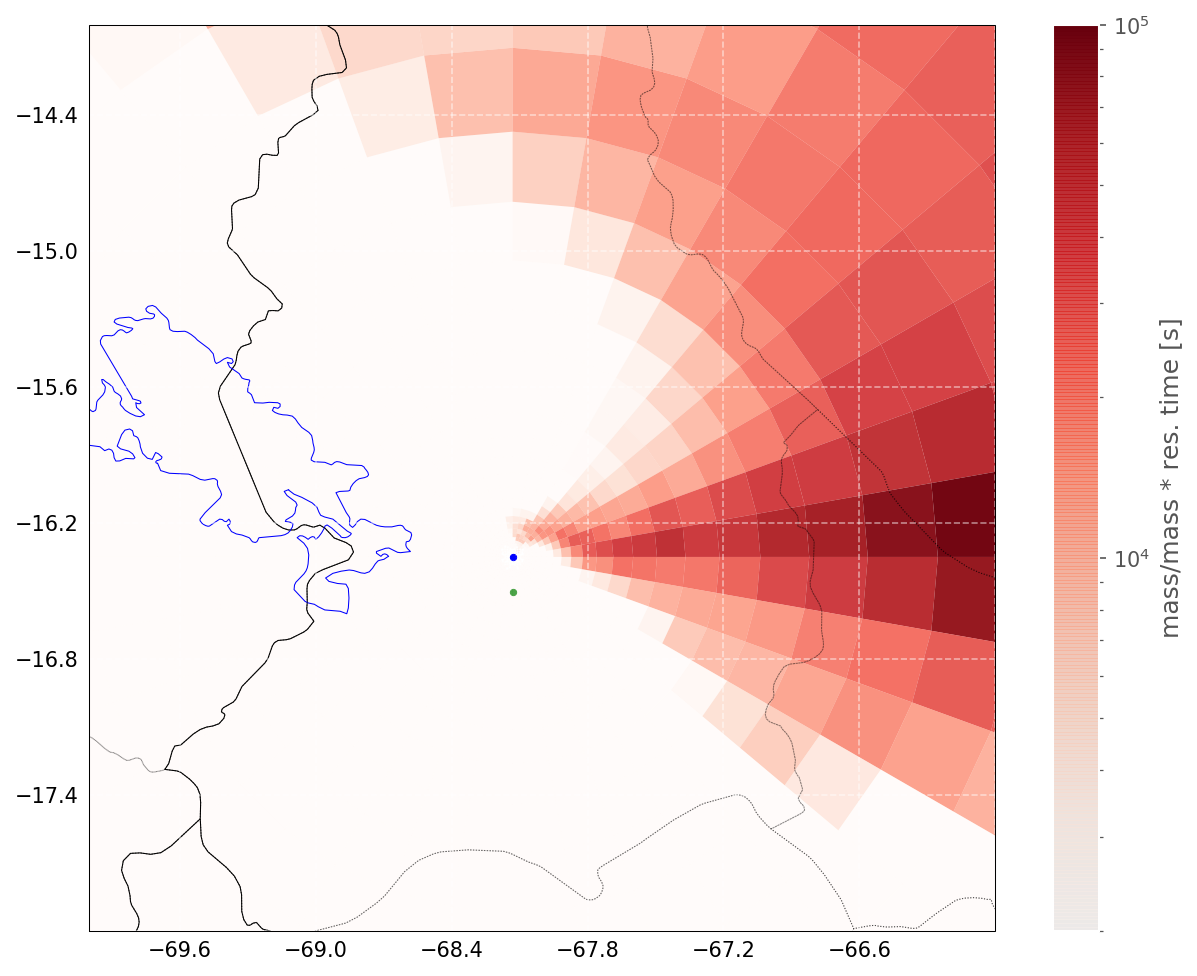

In [12]:

plot_log_custom( dsum , vmax , vmin, map_fun=fa.get_ax_lapaz )
# plt.show()

In [13]:
pass




# main()